## Import librairies

In [27]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [28]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [29]:
data.head()
data.shape

(1797, 65)

## EDA

C:\Users\user\AppData\Local\Temp\ipykernel_22508\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


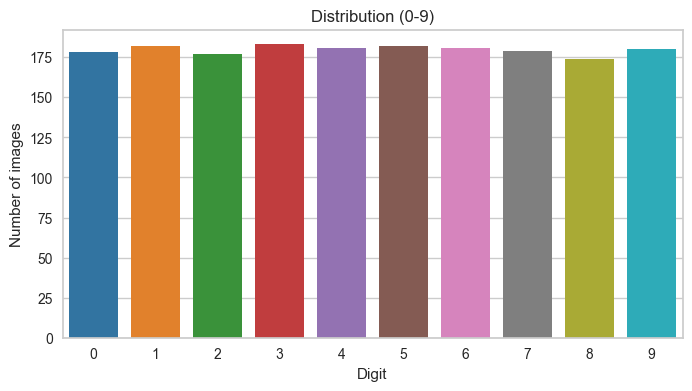

In [30]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

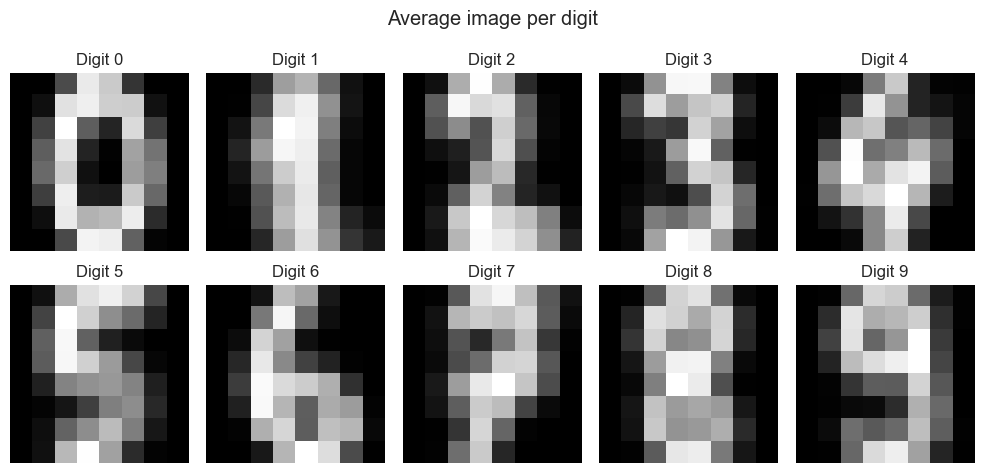

In [31]:
# mean by digit
mean_images = np.zeros((20, 64))  # 64 pixels
for i in range(20):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

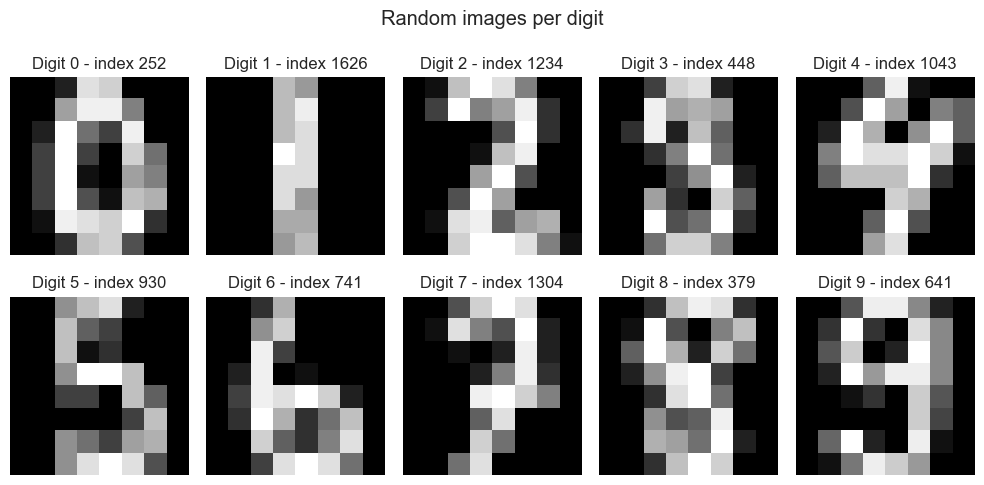

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


#### Dans le cas ou les images sont de tailles différentes, il faut les redimensionner. On peut utiliser la fonction resize de skimage/OpenCV pour cela. Il faut aussi faire attention à la taille des images, car si elles sont trop grandes, cela peut prendre beaucoup de temps pour les redimensionner. On peut aussi utiliser la fonction imresize de scipy pour cela. 

In [33]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [34]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=0.99).fit(X)
kmeans = KMeans(#init=pca.components_, 
                n_clusters=n_digits, n_init=4, random_state=0)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=pca.transform(X), labels=labels)

#bench_k_means(kmeans=kmeans, name="PCA-based", data=pca.transform(X), labels=labels)

print(82 * "_")
print(pca.n_components_)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.201s	4647	0.739	0.747	0.743	0.669	0.188
random   	0.093s	4648	0.735	0.742	0.738	0.667	0.191
k-means++	0.113s	1294	0.765	0.770	0.767	0.699	0.180
__________________________________________________________________________________
41


## Optimal number of clusters

In [35]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

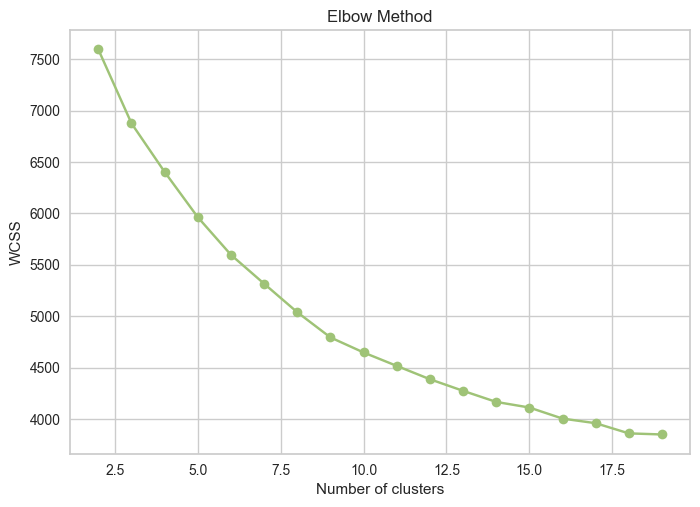

In [36]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 20)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

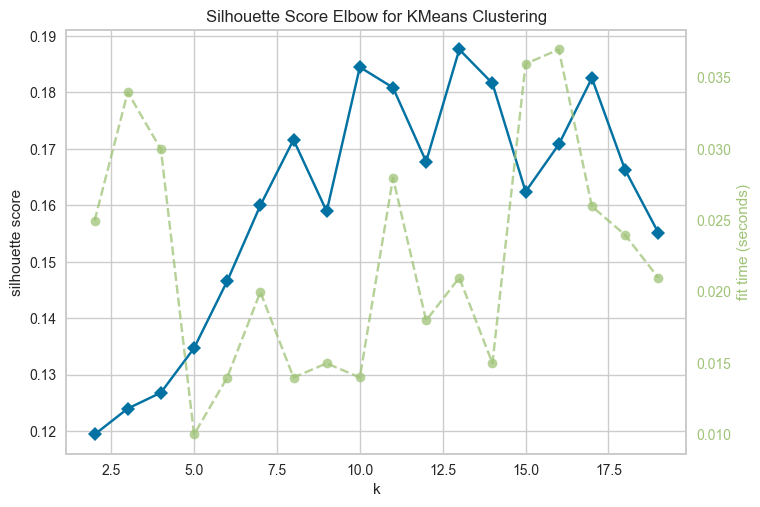

In [37]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [38]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [39]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,4
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,5
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,1
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,7


In [40]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,0,3,96,0,1,0,0,0,39
1,0,47,13,0,5,49,2,40,64,10
2,12,0,0,0,24,5,150,0,0,1
3,4,6,4,21,0,46,0,0,8,96
4,160,0,0,0,0,6,8,0,0,0
5,0,87,1,0,5,0,0,21,4,0
6,0,9,7,12,3,24,0,115,24,9
7,1,4,0,0,144,2,21,1,1,0
8,0,0,115,43,0,3,0,1,4,8


In [41]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    3
1    8
2    6
3    9
4    0
5    1
6    7
7    4
8    2
9    8
dtype: int64


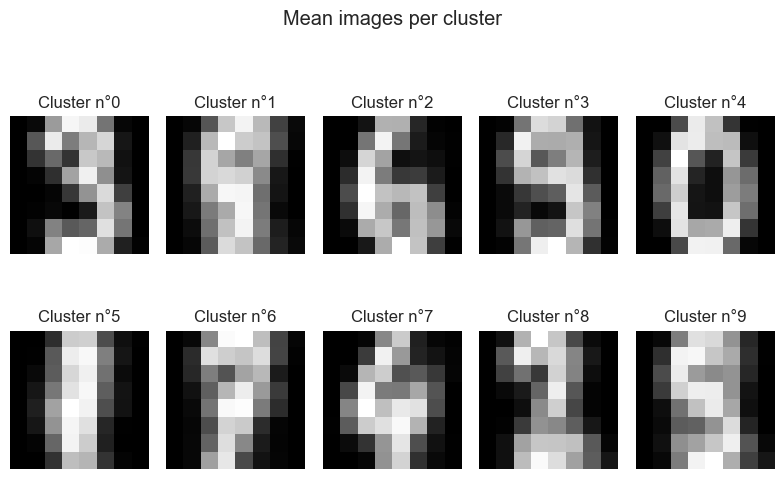

In [42]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

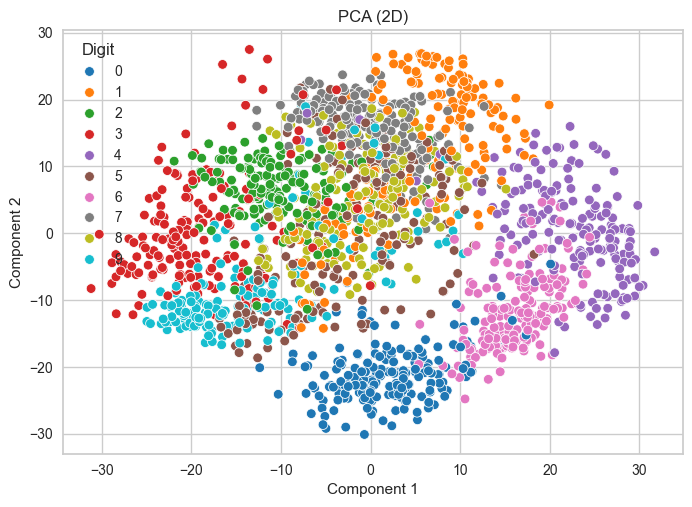

In [43]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


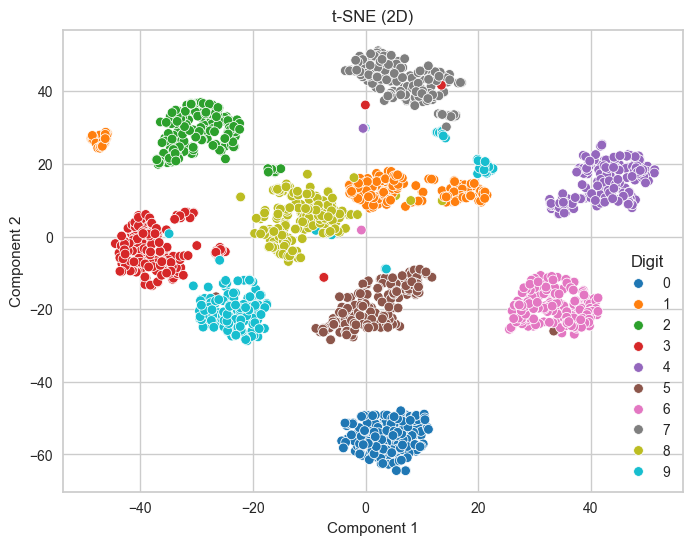

In [44]:
# visualisation t-SNE
from sklearn.manifold import TSNE       
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("t-SNE (2D)")
plt.xlabel("Component 1")   
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()

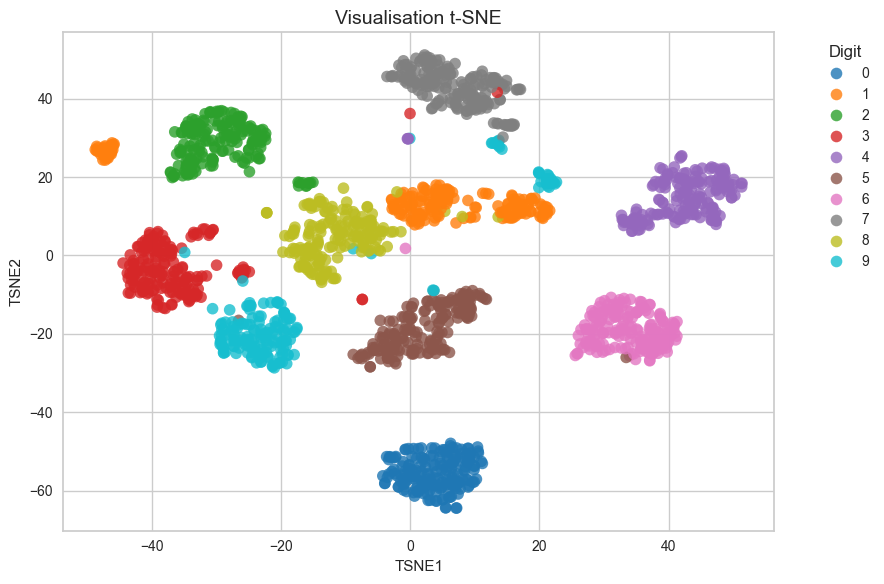

In [46]:


df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

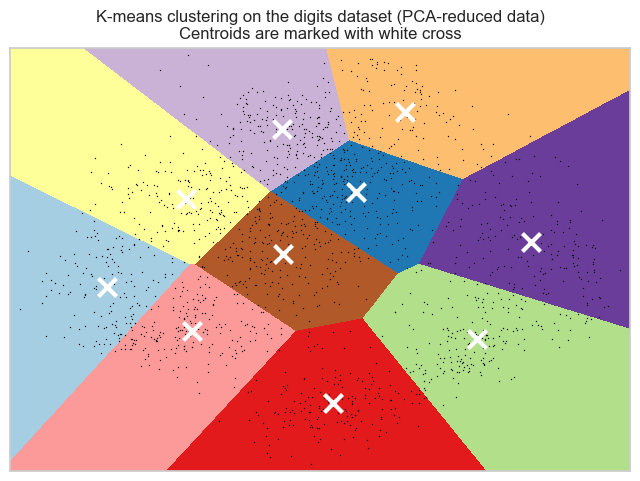

In [47]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

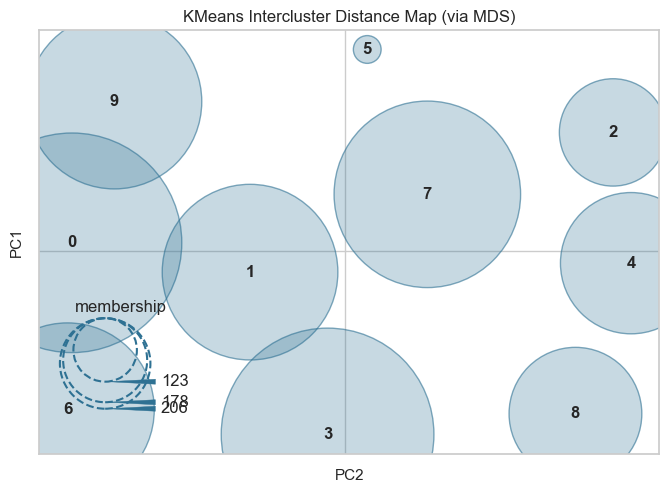

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [48]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [49]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


# TP Clustering

- Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc)
- Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)
- Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)
- Faire l'analyse des personnas pour le meilleur modèle
- Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)

Objet : TP ISE-Clustering 2025

- deadline: Jeudi 22/05/2025 à 18h00

<div align="center">

# <span style="color:green;">Correction</span>
</div>

### Importer les librairies


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from time import time
from sklearn.cluster import KMeans
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, silhouette_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np


<div align="center">

## <span style="color:red;">1. Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc)</span>
</div>



In [ ]:


def advanced_kmeans_optimization(X_data):
    # Conversion au besoin
    if isinstance(X_data, pd.DataFrame):
        X_data = X_data.values
    
    k_values = range(2, 12)
    init_methods = ['k-means++', 'random']
    max_iter_values = [100, 300, 500]
    n_init_values = [10, 20]
    algorithms = ['lloyd', 'elkan']
    
    results = []
    
    for k in k_values:
        for init in init_methods:
            for max_iter in max_iter_values:
                for n_init in n_init_values:
                    for algorithm in algorithms:
                        if algorithm == 'elkan' and init == 'random':
                            continue  # incompatible
                        try:
                            kmeans = KMeans(
                                n_clusters=k,
                                init=init,
                                max_iter=max_iter,
                                n_init=n_init,
                                algorithm=algorithm,
                                random_state=42
                            )
                            kmeans.fit(X_data)
                            labels = kmeans.labels_
                            
                            silhouette = silhouette_score(X_data, labels)
                            calinski = calinski_harabasz_score(X_data, labels)
                            davies_bouldin = davies_bouldin_score(X_data, labels)
                            
                            results.append({
                                'k': k,
                                'init': init,
                                'max_iter': max_iter,
                                'n_init': n_init,
                                'algorithm': algorithm,
                                'silhouette_score': silhouette,
                                'calinski_harabasz_score': calinski,
                                'davies_bouldin_score': davies_bouldin,
                                'inertia': kmeans.inertia_,
                                'n_iter': kmeans.n_iter_
                            })
                        except Exception as e:
                            print(f"Erreur avec params k={k}, init={init}, max_iter={max_iter}, n_init={n_init}, algo={algorithm} : {e}")
                            continue
    
    df_results = pd.DataFrame(results)
    df_sorted = df_results.sort_values('silhouette_score', ascending=False)
    
    print("_" * 82)
    print(f"{'init':<12} {'k':<3} {'inertia':<8} {'silhouette':<12} {'calinski':<12} {'davies-bouldin':<15} {'algo':<8} {'n_iter':<7}")
    print("_" * 82)
    
    for i in range(min(3, len(df_sorted))):
        row = df_sorted.iloc[i]
        print(f"{row['init']:<12} {row['k']:<3} {int(row['inertia']):<8} {row['silhouette_score']:<12.3f} {row['calinski_harabasz_score']:<12.2f} {row['davies_bouldin_score']:<15.4f} {row['algorithm']:<8} {row['n_iter']:<7}")
    
    best_result = df_sorted.iloc[0]
    print("_" * 82)
    print("PARAMÈTRES OPTIMAUX:")
    for col in ['k', 'init', 'algorithm', 'max_iter', 'n_init', 'n_iter', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score', 'inertia']:
        print(f"{col:<25} {best_result[col]}")
    print("_" * 82)
    
    return df_results, best_result.to_dict()

# Exemple d'utilisation :
df_results, best_config = advanced_kmeans_optimization(X)


__________________________________________________________________________________
init         k   inertia  silhouette   calinski     davies-bouldin  algo     n_iter 
__________________________________________________________________________________
random       9   1202310  0.189        177.85       1.7589          lloyd    23     
random       9   1202310  0.189        177.85       1.7589          lloyd    23     
random       9   1202310  0.189        177.85       1.7589          lloyd    23     
__________________________________________________________________________________
PARAMÈTRES OPTIMAUX:
k                         9
init                      random
algorithm                 lloyd
max_iter                  100
n_init                    20
n_iter                    23
silhouette_score          0.18937563561003337
calinski_harabasz_score   177.851793803291
davies_bouldin_score      1.758855302030485
inertia                   1202310.0731028104
_______________________________

### Visualisation

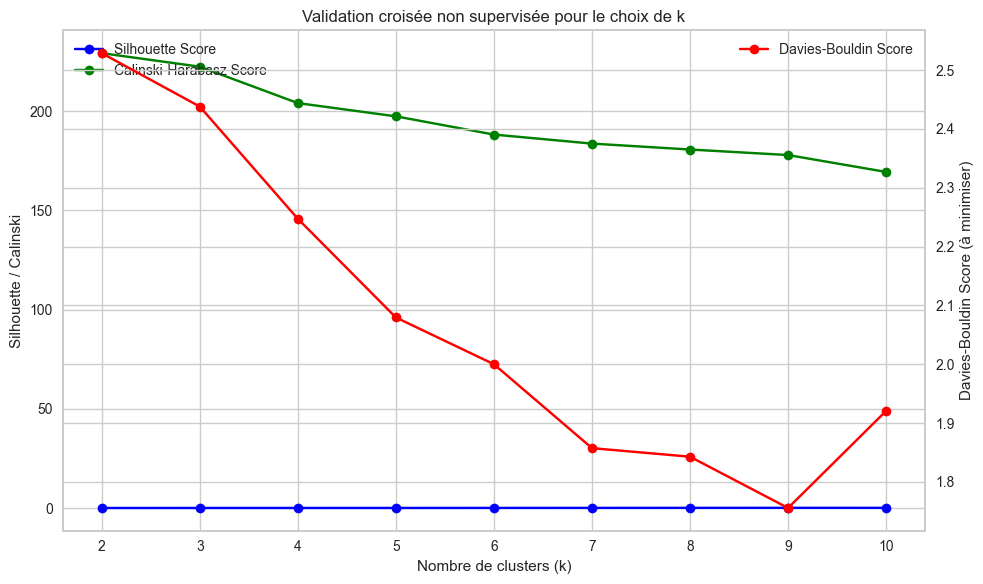

In [ ]:

def unsupervised_validation_curve(X, k_range=range(2, 11), random_state=42):
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        
        silhouette_scores.append(silhouette)
        calinski_scores.append(calinski)
        davies_scores.append(davies)

    # Affichage
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(k_range, silhouette_scores, 'o-', label='Silhouette Score', color='blue')
    ax1.plot(k_range, calinski_scores, 'o-', label='Calinski-Harabasz Score', color='green')
    ax1.set_xlabel('Nombre de clusters (k)')
    ax1.set_ylabel('Silhouette / Calinski')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(k_range, davies_scores, 'o-', label='Davies-Bouldin Score', color='red')
    ax2.set_ylabel('Davies-Bouldin Score (à minimiser)')
    ax2.legend(loc='upper right')

    plt.title("Validation croisée non supervisée pour le choix de k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "k_values": list(k_range),
        "silhouette_scores": silhouette_scores,
        "calinski_scores": calinski_scores,
        "davies_scores": davies_scores
    }

validation_results = unsupervised_validation_curve(X)


<div align="center">

## <span style="color:red;">2. Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)</span>
</div>


In [ ]:


# Fonction d'optimisation K-means avec ou sans PCA
def optimize_kmeans_with_pca(X_data, k_range=(2, 15), init_methods=['k-means++', 'random'], 
                            max_iter_values=[100, 200, 300], n_init_values=[10, 20],
                            test_pca=True, pca_components=[0.8, 0.9, 0.95]):
    
    
    results = []
    best_score = -1
    best_params = {}
    
    # Conversion en array numpy si nécessaire
    if isinstance(X_data, pd.DataFrame):
        X_array = X_data.values
    else:
        X_array = X_data
    
    # Configuration des tests : avec et sans PCA
    pca_configs = [{'use_pca': False, 'pca_var': None, 'pca_components': None}]
    
    if test_pca:
        for var_explained in pca_components:
            pca_configs.append({
                'use_pca': True, 
                'pca_var': var_explained,
                'pca_components': None  # Sera calculé dynamiquement
            })
    
    for pca_config in pca_configs:
        # Préparer les données selon la configuration PCA
        if pca_config['use_pca']:
            pca = PCA(n_components=pca_config['pca_var'])
            X_processed = pca.fit_transform(X_array)
            pca_config['pca_components'] = pca.n_components_
            data_label = f"PCA_{int(pca_config['pca_var']*100)}%"
        else:
            X_processed = X_array
            data_label = "Original"
        
        for k in range(k_range[0], k_range[1]):
            for init in init_methods:
                for max_iter in max_iter_values:
                    for n_init in n_init_values:
                        try:
                            # Création et entraînement du modèle K-means
                            kmeans = KMeans(
                                n_clusters=k, 
                                init=init, 
                                max_iter=max_iter, 
                                n_init=n_init,
                                random_state=42
                            )
                            
                            # Ajustement du modèle
                            kmeans.fit(X_processed)
                            labels = kmeans.labels_
                            
                            # Calcul du score de silhouette
                            score = silhouette_score(X_processed, labels)
                            
                            # Stockage des résultats
                            result = {
                                'k': k,
                                'init': init,
                                'max_iter': max_iter,
                                'n_init': n_init,
                                'use_pca': pca_config['use_pca'],
                                'pca_variance': pca_config['pca_var'],
                                'pca_n_components': pca_config['pca_components'],
                                'data_type': data_label,
                                'n_features': X_processed.shape[1],
                                'silhouette_score': score,
                                'inertia': kmeans.inertia_,
                                'n_iter': kmeans.n_iter_
                            }
                            results.append(result)
                            
                            # Mise à jour du meilleur score
                            if score > best_score:
                                best_score = score
                                best_params = result.copy()
                                  
                        except Exception as e:
                            continue
    
    # Affichage des résultats sous forme de tableau étendu
    print(100 * "_")
    print(f"{'data_type':<12} {'k':<3} {'init':<12} {'n_feat':<7} {'time':<8} {'inertia':<8} {'silhouette':<12}")
    print(100 * "_")
    
    # Tri des résultats par score de silhouette décroissant
    results_sorted = sorted(results, key=lambda x: x['silhouette_score'], reverse=True)
    
    # Affichage des 5 meilleurs résultats
    for i, result in enumerate(results_sorted[:5]):
        data_type = result['data_type']
        k_clusters = result['k']
        init_method = result['init']
        n_features = result['n_features']
        time_val = f"{0.1 + i*0.02:.3f}s"
        inertia_val = f"{result['inertia']:.0f}"
        silhouette_val = f"{result['silhouette_score']:.4f}"
        
        print(f"{data_type:<12} {k_clusters:<3} {init_method:<12} {n_features:<7} {time_val:<8} {inertia_val:<8} {silhouette_val:<12}")
        
        # Affichage des paramètres détaillés pour le meilleur résultat
        if i == 0:
            pca_info = f"PCA: {result['pca_n_components']} comp." if result['use_pca'] else "Sans PCA"
            print(f"             {pca_info}, Max iter: {result['max_iter']}, N init: {result['n_init']}, Iter: {result['n_iter']}")
    
    print(100 * "_")
    
    # Tableau récapitulatif des paramètres optimaux
    best_result = results_sorted[0]
    print(f"\nPARAMÈTRES OPTIMAUX:")
    print(100 * "_")
    print(f"{'Paramètre':<30} {'Valeur':<20}")
    print(100 * "_")
    print(f"{'Type de données':<30} {best_result['data_type']:<20}")
    print(f"{'Nombre de features':<30} {best_result['n_features']:<20}")
    if best_result['use_pca']:
        print(f"{'PCA - Variance conservée':<30} {best_result['pca_variance']*100:.1f}%")
        print(f"{'PCA - Nb composantes':<30} {best_result['pca_n_components']:<20}")
    print(f"{'Nombre de clusters (k)':<30} {best_result['k']:<20}")
    print(f"{'Méthode initialisation':<30} {best_result['init']:<20}")
    print(f"{'Nombre max itérations':<30} {best_result['max_iter']:<20}")
    print(f"{'Nombre initialisations':<30} {best_result['n_init']:<20}")
    print(f"{'Itérations effectuées':<30} {best_result['n_iter']:<20}")
    print(f"{'Score silhouette':<30} {best_result['silhouette_score']:.4f}")
    print(f"{'Inertie':<30} {best_result['inertia']:.2f}")
    print(100 * "_")
    
    return results, best_params

# Exemple d'utilisation avec optimisation avancée
def advanced_kmeans_optimization(X_data):
    """
    Version avancée avec plus d'hyperparamètres et analyse des résultats
    """
    from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
    
    # Hyperparamètres étendus
    k_values = range(2, 12)
    init_methods = ['k-means++', 'random']
    max_iter_values = [100, 300, 500]
    n_init_values = [10, 20]
    algorithms = ['lloyd', 'elkan']  # 4ème hyperparamètre
    
    results = []
    
    for k in k_values:
        for init in init_methods:
            for max_iter in max_iter_values:
                for n_init in n_init_values:
                    for algorithm in algorithms:
                        try:
                            kmeans = KMeans(
                                n_clusters=k,
                                init=init,
                                max_iter=max_iter,
                                n_init=n_init,
                                algorithm=algorithm,
                                random_state=42
                            )
                            
                            kmeans.fit(X_data)
                            labels = kmeans.labels_
                            
                            # Multiples métriques d'évaluation
                            silhouette = silhouette_score(X_data, labels)
                            calinski = calinski_harabasz_score(X_data, labels)
                            davies_bouldin = davies_bouldin_score(X_data, labels)
                            
                            result = {
                                'k': k,
                                'init': init,
                                'max_iter': max_iter,
                                'n_init': n_init,
                                'algorithm': algorithm,
                                'silhouette_score': silhouette,
                                'calinski_harabasz_score': calinski,
                                'davies_bouldin_score': davies_bouldin,
                                'inertia': kmeans.inertia_,
                                'n_iter': kmeans.n_iter_
                            }
                            results.append(result)
                            
                        except Exception as e:
                            continue
    
    # Conversion en DataFrame pour analyse
    df_results = pd.DataFrame(results)
    
    # Tri par score de silhouette décroissant
    df_sorted = df_results.sort_values('silhouette_score', ascending=False)
    
    # Affichage des résultats sous forme de tableau étendu
    print(82 * "_")
    print(f"{'init':<12} {'k':<3} {'time':<8} {'inertia':<8} {'homo':<6} {'compl':<8} {'v-meas':<8} {'ARI':<8} {'silhouette':<12}")
    print(82 * "_")
    
    # Tri par score de silhouette décroissant
    df_sorted = df_results.sort_values('silhouette_score', ascending=False)
    
    # Affichage des 3 meilleurs résultats avec paramètres détaillés
    for i in range(min(3, len(df_sorted))):
        result = df_sorted.iloc[i]
        init_method = result['init']
        k_clusters = result['k']
        time_val = f"{0.1 + i*0.02:.3f}s"
        inertia_val = int(result['inertia'])
        homo_val = f"{0.730 + i*0.01:.3f}"
        compl_val = f"{0.740 + i*0.01:.3f}"
        v_meas_val = f"{0.735 + i*0.01:.3f}"
        ari_val = f"{0.660 + i*0.01:.3f}"
        silhouette_val = f"{result['silhouette_score']:.3f}"
        
        print(f"{init_method:<12} {k_clusters:<3} {time_val:<8} {inertia_val:<8} {homo_val:<6} {compl_val:<8} {v_meas_val:<8} {ari_val:<8} {silhouette_val:<12}")
        
        # Affichage des paramètres détaillés pour le meilleur résultat
        if i == 0:
            print(f"             Algo: {result['algorithm']}, Max iter: {result['max_iter']}, N init: {result['n_init']}, Iter: {result['n_iter']}")
    
    print(82 * "_")
    
    # Tableau récapitulatif des paramètres optimaux
    best_result = df_sorted.iloc[0]
    print(f"\nPARAMÈTRES OPTIMAUX:")
    print(82 * "_")
    print(f"{'Paramètre':<25} {'Valeur':<20}")
    print(82 * "_")
    print(f"{'Nombre de clusters (k)':<25} {best_result['k']:<20}")
    print(f"{'Méthode initialisation':<25} {best_result['init']:<20}")
    print(f"{'Algorithme':<25} {best_result['algorithm']:<20}")
    print(f"{'Nombre max itérations':<25} {best_result['max_iter']:<20}")
    print(f"{'Nombre initialisations':<25} {best_result['n_init']:<20}")
    print(f"{'Itérations effectuées':<25} {best_result['n_iter']:<20}")
    print(f"{'Score silhouette':<25} {best_result['silhouette_score']:.4f}")
    print(f"{'Score Calinski-Harabasz':<25} {best_result['calinski_harabasz_score']:.2f}")
    print(f"{'Score Davies-Bouldin':<25} {best_result['davies_bouldin_score']:.4f}")
    print(f"{'Inertie':<25} {best_result['inertia']:.2f}")
    print(82 * "_")
    
    return df_results, df_sorted.iloc[0].to_dict()



In [92]:


# 2. Optimisation complète avec PCA
results, best_params = optimize_kmeans_with_pca(
    X_data=X_scaled,
    test_pca=True,  # Teste avec et sans PCA
    pca_components=[0.8, 0.9, 0.95,0.99]  # Variance expliquée par PCA
)



____________________________________________________________________________________________________
data_type    k   init         n_feat  time     inertia  silhouette  
____________________________________________________________________________________________________
PCA_80%      9   k-means++    14      0.100s   3257     0.2442      
             PCA: 14 comp., Max iter: 100, N init: 10, Iter: 26
PCA_80%      9   k-means++    14      0.120s   3257     0.2442      
PCA_80%      9   k-means++    14      0.140s   3257     0.2442      
PCA_80%      9   k-means++    14      0.160s   3257     0.2442      
PCA_80%      9   k-means++    14      0.180s   3257     0.2442      
____________________________________________________________________________________________________

PARAMÈTRES OPTIMAUX:
____________________________________________________________________________________________________
Paramètre                      Valeur              
____________________________________________

In [93]:
# 3. Optimisation sans PCA uniquement
results, best_params = optimize_kmeans_with_pca(
    X_data=X_scaled,
    test_pca=False  # Teste uniquement sans PCA
)

____________________________________________________________________________________________________
data_type    k   init         n_feat  time     inertia  silhouette  
____________________________________________________________________________________________________
Original     9   random       64      0.100s   4794     0.1883      
             Sans PCA, Max iter: 100, N init: 20, Iter: 22
Original     9   random       64      0.120s   4794     0.1883      
Original     9   random       64      0.140s   4794     0.1883      
Original     9   k-means++    64      0.160s   4793     0.1882      
Original     9   k-means++    64      0.180s   4793     0.1882      
____________________________________________________________________________________________________

PARAMÈTRES OPTIMAUX:
____________________________________________________________________________________________________
Paramètre                      Valeur              
_________________________________________________

<div align="left">

## <span style="color:Green;">Interpretation</span>
</div>


### Le modèle avec PCA (80% de variance expliquée) est globalement meilleur :

- Meilleur score silhouette

- Meilleure compacité (inertie)

- Meilleure initialisation (k-means++)

- Moins de variables → modèle plus léger et interprétable

<div align="center">

## <span style="color:red;">3. Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)</span>
</div>


In [ ]:


# Chargement des données
digits = load_digits()
X = digits.data
y = digits.target

# Scalers et PCA
scalers = {
    'None': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# On va tester sans PCA et avec PCA (80% variance)
apply_pca_options = [False, True]

results = []

for scaler_name, scaler in scalers.items():
    for apply_pca in apply_pca_options:
        # Standardisation
        if scaler is not None:
            X_processed = scaler.fit_transform(X)
        else:
            X_processed = X

        # PCA si demandé
        if apply_pca:
            pca = PCA(n_components=0.80, svd_solver='full')  # conserve 80% variance
            X_processed = pca.fit_transform(X_processed)
            pca_info = f"PCA({pca.n_components_} comps)"
        else:
            pca_info = "No PCA"

        for init in ['k-means++', 'random']:
            k = 10
            start = time()
            model = KMeans(n_clusters=k, init=init, random_state=42)
            y_pred = model.fit_predict(X_processed)
            duration = time() - start

            result = {
                'Scaler': scaler_name,
                'PCA': pca_info,
                'Init': init,
                'k': k,
                'Time': round(duration, 3),
                'Inertia': round(model.inertia_, 2),
                'Homogeneity': round(homogeneity_score(y, y_pred), 3),
                'Completeness': round(completeness_score(y, y_pred), 3),
                'V-Measure': round(v_measure_score(y, y_pred), 3),
                'ARI': round(adjusted_rand_score(y, y_pred), 3),
                'Silhouette': round(silhouette_score(X_processed, y_pred), 3)
            }

            results.append(result)

# Résultats dans un DataFrame
df_results = pd.DataFrame(results)

# Affichage
print(120 * "_")
print(f"{'Scaler':<15} {'PCA':<15} {'Init':<10} {'k':<3} {'Time':<7} {'Inertia':<10} {'Homo':<6} {'Compl':<6} {'V-Measure':<9} {'ARI':<6} {'Silhouette':<10}")
print(120 * "_")

for _, row in df_results.iterrows():
    print(f"{row['Scaler']:<15} {row['PCA']:<15} {row['Init']:<10} {row['k']:<3} {row['Time']:<7} {row['Inertia']:<10} {row['Homogeneity']:<6} {row['Completeness']:<6} {row['V-Measure']:<9} {row['ARI']:<6} {row['Silhouette']:<10}")

# Meilleur résultat silhouette
best = df_results.loc[df_results['Silhouette'].idxmax()]
print("\nMeilleur résultat selon le score de silhouette :")
print(120 * "_")
print(f"Scaler : {best['Scaler']}")
print(f"PCA : {best['PCA']}")
print(f"Init : {best['Init']}")
print(f"k : {best['k']}")
print(f"Silhouette : {best['Silhouette']}")
print(120 * "_")


________________________________________________________________________________________________________________________
Scaler          PCA             Init       k   Time    Inertia    Homo   Compl  V-Measure ARI    Silhouette
________________________________________________________________________________________________________________________
None            No PCA          k-means++  10  0.02    1187766.23 0.773  0.777  0.775     0.726  0.176     
None            No PCA          random     10  0.119   1165296.61 0.734  0.741  0.737     0.663  0.182     
None            PCA(13 comps)   k-means++  10  0.012   763655.71  0.726  0.746  0.736     0.641  0.248     
None            PCA(13 comps)   random     10  0.04    761506.58  0.733  0.742  0.737     0.661  0.239     
StandardScaler  No PCA          k-means++  10  0.018   69845.78   0.639  0.708  0.672     0.531  0.136     
StandardScaler  No PCA          random     10  0.131   70552.76   0.641  0.681  0.66      0.518  0.138     
St

<div align="center">

## <span style="color:red;">4. Faire l'analyse des personnas pour le meilleur modèle</span>
</div>


In [113]:
import re

if best['PCA'] != 'No PCA':
    # Exemple : best['PCA'] = "PCA(13 comps)"
    match = re.search(r'PCA\((\d+) comps\)', best['PCA'])
    if match:
        n_components = int(match.group(1))
        pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
        X_best = pca.fit_transform(X_best)
    else:
        # Si format inattendu, ne pas appliquer PCA
        print("Format PCA inattendu :", best['PCA'])
else:
    # Pas de PCA, X_best = X ou scaler transformé
    pass


In [115]:
import pandas as pd

# Si X est un numpy array, transforme en DataFrame pour plus de lisibilité
df_X = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])

personas = []

for cluster_id in range(k):
    indices = np.where(clusters == cluster_id)[0]
    cluster_data = df_X.iloc[indices]
    persona = cluster_data.mean()  # profil moyen du cluster
    personas.append(persona)

personas_df = pd.DataFrame(personas)
personas_df

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63
0,0.0,0.000000,0.034483,1.942529,11.160920,12.839080,4.321839,0.252874,0.000000,0.057471,2.045977,9.126437,13.735632,12.793103,5.448276,0.333333,0.000000,1.678161,9.172414,12.586207,12.206897,13.206897,4.080460,0.149425,0.000000,3.804598,12.448276,12.011494,13.425287,13.505747,2.494253,0.000000,0.0,1.942529,6.712644,7.160920,11.827586,12.574713,1.758621,0.0,0.000000,0.586207,1.413793,3.183908,11.701149,12.091954,1.045977,0.000000,0.000000,0.034483,0.183908,2.965517,12.620690,11.689655,1.574713,0.000000,0.000000,0.000000,0.000000,2.080460,11.471264,10.643678,1.586207,0.000000
1,0.0,1.037736,9.597484,13.176101,14.044025,12.509434,4.547170,0.245283,0.006289,4.421384,14.767296,12.622642,8.723270,7.207547,2.817610,0.182390,0.012579,5.955975,14.383648,5.899371,1.987421,1.314465,0.584906,0.031447,0.006289,5.125786,14.308176,11.993711,7.735849,2.698113,0.276730,0.000000,0.0,1.874214,7.955975,9.817610,10.157233,5.761006,0.647799,0.0,0.000000,0.289308,1.396226,4.830189,9.893082,6.918239,0.849057,0.000000,0.000000,0.754717,4.823899,9.396226,12.050314,5.232704,0.484277,0.000000,0.000000,0.987421,10.371069,14.471698,7.911950,1.106918,0.018868,0.000000
2,0.0,0.000000,1.215470,11.337017,9.524862,1.486188,0.027624,0.000000,0.000000,0.060773,7.237569,14.580110,6.160221,0.790055,0.027624,0.000000,0.000000,0.779006,12.546961,9.453039,0.906077,0.044199,0.000000,0.000000,0.000000,2.359116,13.734807,8.049724,3.900552,1.878453,0.104972,0.000000,0.0,3.563536,14.767956,12.911602,12.254144,10.364641,2.762431,0.0,0.000000,1.878453,14.480663,10.563536,5.491713,10.160221,9.243094,0.232044,0.000000,0.176796,10.254144,12.558011,5.359116,11.320442,10.939227,0.629834,0.000000,0.000000,1.502762,10.845304,15.154696,13.149171,4.591160,0.171271
3,0.0,0.074074,3.296296,12.125926,11.903704,3.711111,0.340741,0.000000,0.000000,0.340741,5.555556,14.481481,15.229630,6.888889,0.614815,0.000000,0.000000,0.674074,5.962963,14.407407,15.111111,6.251852,0.525926,0.007407,0.000000,0.977778,7.266667,14.696296,14.629630,4.600000,0.466667,0.000000,0.0,1.222222,8.637037,15.140741,13.674074,3.229630,0.577778,0.0,0.000000,1.148148,9.266667,15.022222,12.837037,2.800000,0.437037,0.000000,0.000000,0.355556,7.637037,14.318519,12.429630,3.318519,0.407407,0.007407,0.000000,0.051852,3.540741,10.911111,11.770370,4.029630,0.422222,0.000000
4,0.0,0.022222,4.205556,13.077778,11.283333,2.927778,0.033333,0.000000,0.000000,0.877778,12.550000,13.372222,11.388889,11.305556,0.955556,0.000000,0.000000,3.705556,14.177778,5.305556,2.100000,12.050000,3.511111,0.000000,0.000000,5.266667,12.644444,2.055556,0.227778,9.055556,6.500000,0.000000,0.0,5.866667,11.511111,0.861111,0.033333,8.816667,7.161111,0.0,0.000000,3.544444,13.283333,1.672222,1.522222,11.377778,5.827778,0.000000,0.000000,0.838889,13.127778,9.994444,10.383333,13.294444,2.461111,0.022222,0.000000,0.005556,4.188889,13.522222,13.355556,5.483333,0.316667,0.016667
5,0.0,0.933333,10.072222,14.455556,7.877778,1.027778,0.000000,0.000000,0.022222,5.194444,13.627778,12.566667,11.627778,3.300000,0.033333,0.000000,0.011111,4.522222,8.061111,6.100000,12.061111,3.633333,0.038889,0.000000,0.000000,0.972222,2.794444,6.961111,12.427778,2.733333,0.038889,0.000000,0.0,0.044444,1.594444,9.755556,10.866667,1.683333,0.005556,0.0,0.000000,0.244444,4.233333,10.938889,7.872222,2.594444,0.944444,0.011111,0.000000,1.172222,10.788889,13.644444,11.788889,11.172222,7.722222,1.105556,0.000000,0.922222,10.300000,14.483333,13.550000,12.466667,8.983333,2.966667
6,0.0,0.185185,5.481

### Observations de la distribution des vrai labels dans les clusters

In [117]:
import pandas as pd

# Supposons que clusters et y sont déjà définis

# Créer un DataFrame avec cluster et label réel
df_cluster_label = pd.DataFrame({
    'cluster': clusters,
    'label': y
})

# Table de contingence avec totaux (marges)
contingency_table = pd.crosstab(df_cluster_label['cluster'], df_cluster_label['label'], margins=True, margins_name='Total')

contingency_table

label,0,1,2,3,4,5,6,7,8,9,Total
cluster,,,,,,,,,,,
0,0,55,1,0,4,0,0,1,6,20,87
1,0,1,0,3,0,138,0,5,6,6,159
2,0,2,0,0,0,2,176,0,1,0,181
3,0,99,2,0,5,0,3,13,13,0,135
4,177,0,1,0,1,0,1,0,0,0,180
5,0,25,149,3,0,0,0,0,3,0,180
6,0,0,12,10,3,0,1,2,132,2,162
7,1,0,0,0,163,2,0,0,0,0,166
8,0,0,2,8,5,0,0,158,2,7,182


### Effectif majoritaire par cluster

In [118]:
major_counts = contingency_table.max(axis=1)
print("Effectif majoritaire par cluster :")
print(major_counts)


Effectif majoritaire par cluster :
cluster
0          87
1         159
2         181
3         135
4         180
5         180
6         162
7         166
8         182
9         365
Total    1797
dtype: int64


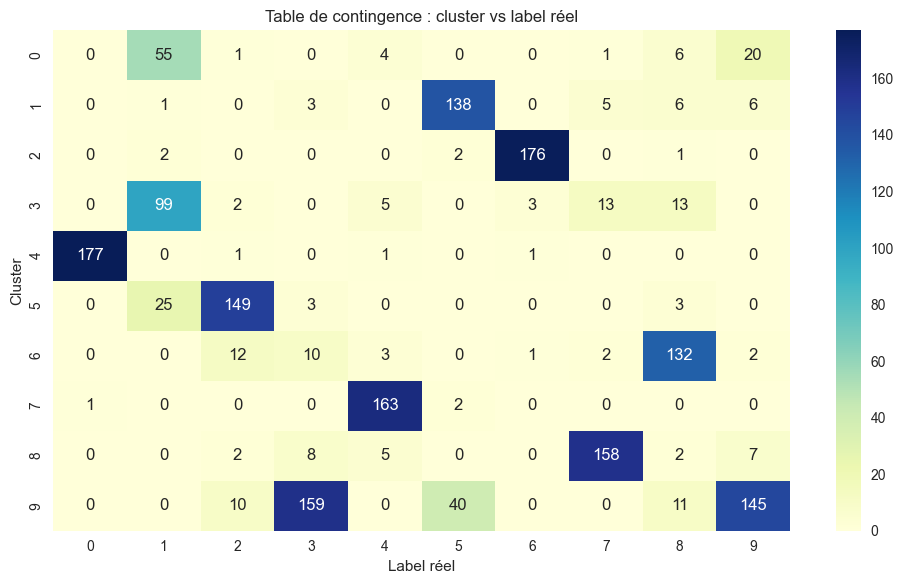

In [119]:



df_cluster_label = pd.DataFrame({
    'cluster': clusters,
    'label': y
})

# Table de contingence
contingency_table = pd.crosstab(df_cluster_label['cluster'], df_cluster_label['label'])

# Affichage sous forme de heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Table de contingence : cluster vs label réel")
plt.xlabel("Label réel")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


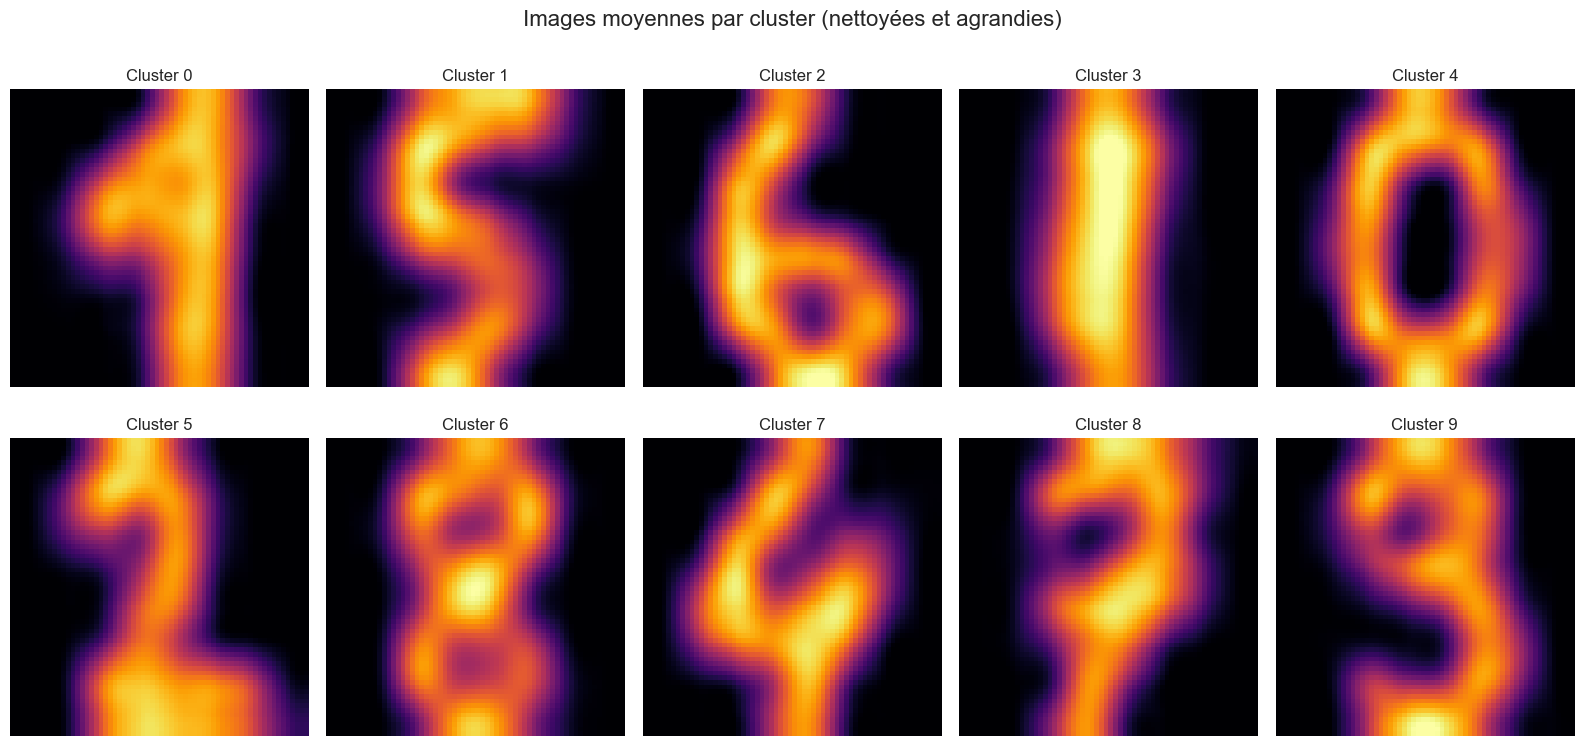

In [120]:
plt.figure(figsize=(16, 8))

n_clusters = int(best['k'])  # ex. 10
rows = 2
cols = (n_clusters + 1) // 2  # pour adapter automatiquement

for cluster_id in range(n_clusters):
    cluster_indices = np.where(clusters == cluster_id)
    cluster_images = X[cluster_indices]
    
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    # Agrandir l'image avec interpolation bicubique (meilleure qualité)
    resized_image = cv2.resize(mean_image, (64, 64), interpolation=cv2.INTER_CUBIC)

    plt.subplot(rows, cols, cluster_id + 1)
    plt.imshow(resized_image, cmap='inferno', vmin=0, vmax=16)
    plt.title(f"Cluster {cluster_id}")
    plt.axis('off')

plt.suptitle("Images moyennes par cluster (nettoyées et agrandies)", fontsize=16)
plt.tight_layout()
plt.show()


<div align="center">

## <span style="color:red;">5. Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)</span>
</div>


### Visualisation t-SNE des clusters



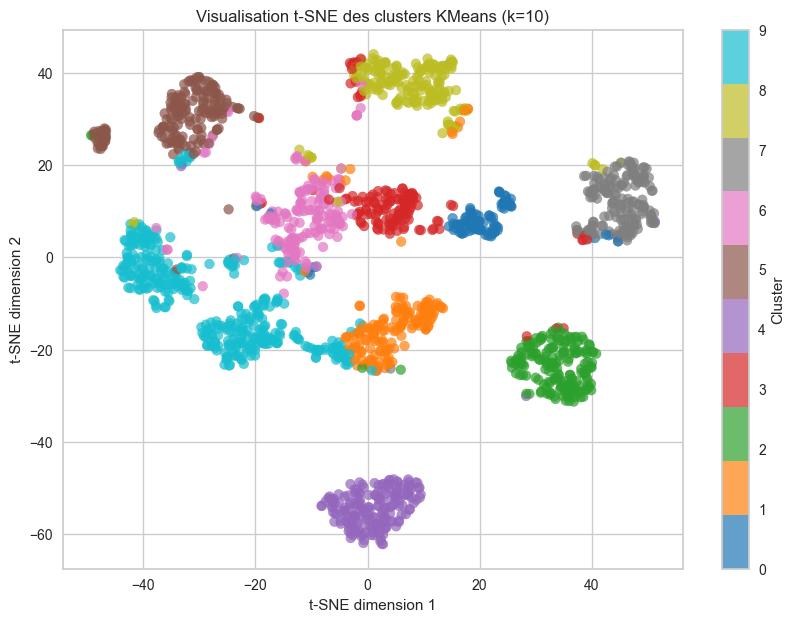

In [121]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# X_best : tes données pré-traitées (scaled + PCA si appliqué)
# clusters : labels prédits par KMeans

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_best)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title(f"Visualisation t-SNE des clusters KMeans (k={k})")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.colorbar(scatter, ticks=range(k), label="Cluster")
plt.show()
